In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
from smsl.plotAgent import PlotAgent, palette
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from IPython.display import JSON

In [4]:
## declare subgroups
s2index_col = {
'bm' : [0,1,2],
'hb' : [0,1],
'st' : [0,1],
'rb' : 0,
'pr0': 0,
'pr1': 0,
}
subgroups = list(s2index_col.keys())
## load ks avg data in each position and each subgroup
s2df_ks_position_avg = {}
for s, index_col in s2index_col.items():
    s2df_ks_position_avg[s] = pd.read_csv(f'data/{s}_avg.csv', index_col=index_col)
## Modify the index of s = pr1, ex: 'G3G4' -> 'G3\nG4'
import re
sequences = s2df_ks_position_avg['pr1'].index.to_list()
sequence_splits = []
for sequence in sequences:
    sequence_split = re.findall(r"([A-Za-z]+)(\d+)", sequence)
    sequence_split = ''.join(sequence_split[0])+'\n'+''.join(sequence_split[1])
    sequence_splits.append(sequence_split)
s2df_ks_position_avg['pr1'].index = sequence_splits

In [5]:
## load ks std data in each position and each subgroup
s2df_ks_position_std = {}
for s, index_col in s2index_col.items():
    s2df_ks_position_std[s] = pd.read_csv(f'data/{s}_std.csv', index_col=index_col)
## Modify the index of s = pr1, ex: 'G3G4' -> 'G3\nG4'
import re
sequences = s2df_ks_position_std['pr1'].index.to_list()
sequence_splits = []
for sequence in sequences:
    sequence_split = re.findall(r"([A-Za-z]+)(\d+)", sequence)
    sequence_split = ''.join(sequence_split[0])+'\n'+''.join(sequence_split[1])
    sequence_splits.append(sequence_split)
s2df_ks_position_std['pr1'].index = sequence_splits

In [32]:
plt.rcParams['svg.fonttype'] = 'none' ## set the text in svg file as <text> instead of <path>

def vsplot(system_offical_name2label, is_error_bar=True):
    capsize, elinewidth = (3, None) if is_error_bar else (0, 0)
    fig = plt.figure(figsize=[8.0, 9.5], dpi=100)
    gs = GridSpec(33, 18, figure=fig)

    # Create subplots
    ax_bm = [fig.add_subplot(gs[0:3, 1:6]), fig.add_subplot(gs[3:6, 1:6]), fig.add_subplot(gs[6:9, 1:6]), fig.add_subplot(gs[9:12, 1:6])]
    ax_hb = [fig.add_subplot(gs[0:4, 7:12]), fig.add_subplot(gs[4:8, 7:12]), fig.add_subplot(gs[8:12, 7:12])]
    ax_st = [fig.add_subplot(gs[0:6, 13:18]), fig.add_subplot(gs[6:12, 13:18])]
    ax_rb = fig.add_subplot(gs[13:19, 1:18])
    ax_pr0 = fig.add_subplot(gs[20:26, 1:18])
    ax_pr1 = fig.add_subplot(gs[27:33, 1:18])

    # Plotting for ax_bm, ax_hb, and ax_st
    for s, ax in zip(['bm', 'hb', 'st'], [ax_bm, ax_hb, ax_st]):
        for shift, (system, system_offical_name) in enumerate(system_offical_name2label.items()):
            df_loc_avg = s2df_ks_position_avg[s].loc[system]
            df_loc_std = s2df_ks_position_std[s].loc[system]
            for i, ((layer, df_iter_avg), (layer, df_iter_std)) in enumerate(zip(df_loc_avg.iterrows(), df_loc_std.iterrows())):
                k_flatten_avg = df_iter_avg.to_numpy().flatten()
                k_flatten_std = df_iter_std.to_numpy().flatten()
                if s=='st':
                    ax[i].errorbar(np.arange(len(k_flatten_avg)), k_flatten_avg, yerr=k_flatten_std, fmt='o-', markersize=4, capsize=capsize, elinewidth=elinewidth, label=system_offical_name)
                else:
                    ax[i].errorbar(np.arange(len(k_flatten_avg)), k_flatten_avg, yerr=k_flatten_std, fmt='o-', markersize=4, capsize=capsize, elinewidth=elinewidth)
                if s=='hb':
                    ax[i].set_ylabel(' '.join(layer) if type(layer)!=str else layer, fontdict=font_label, labelpad=-2)
                else:
                    ax[i].set_ylabel(' '.join(layer) if type(layer)!=str else layer, fontdict=font_label, labelpad=0)
        ax[0].set_title(r'$k^{\rm{'+s+'}}$', fontdict=font_label)
        ax[-1].set_xticks(range(len(k_flatten_avg)), df_iter_avg.keys(), rotation=0)
        ax[-1].set_xticklabels(df_iter_avg.keys(), fontdict=font_xyticks)
        ylim_max = (s2df_ks_position_avg[s]+s2df_ks_position_std[s]).loc[list(system_offical_name2label.keys())].to_numpy().flatten().max()
        ylim_min = (s2df_ks_position_avg[s]-s2df_ks_position_std[s]).loc[list(system_offical_name2label.keys())].to_numpy().flatten().min()
        ylim_max += 0.08 * (ylim_max - ylim_min)
        ylim_min -= 0.08 * (ylim_max - ylim_min)
        ax[-1].set_ylim(ylim_min, ylim_max)
        ax[-1].set_yticks(range(int(max(ylim_min,0)), int(ylim_max) + 2, int((int(ylim_max)-int(max(ylim_min,0)))/2)))

    # Share y-axis for ax_bm, ax_hb, and ax_st
    for axs in [ax_bm, ax_hb, ax_st]:
        for ax in axs[:-1]:
            ax.sharey(axs[-1])
            ax.sharex(axs[-1])
            ax.get_xaxis().set_visible(False)

    # Plotting for ax_rb, ax_pr0, and ax_pr1
    for s, ax in zip(['rb', 'pr0', 'pr1'], [ax_rb, ax_pr0, ax_pr1]):
        for shift, (system, system_offical_name) in enumerate(system_offical_name2label.items()):
            df_loc_avg = s2df_ks_position_avg[s][system]
            df_loc_std = s2df_ks_position_std[s][system]
            k_flatten_avg = df_loc_avg.to_numpy().flatten()
            k_flatten_std = df_loc_std.to_numpy().flatten()
            ax.errorbar(np.arange(len(k_flatten_avg)), k_flatten_avg, yerr=k_flatten_std, fmt='o-', markersize=4, capsize=capsize, elinewidth=elinewidth)
        ax.set_xticks(range(len(k_flatten_avg)), df_loc_avg.keys(), rotation=0)
        ax.set_xticklabels(df_loc_avg.keys(), fontdict=font_xyticks)
        ax.set_ylabel(r'$k^{\rm{'+s+'}}$', fontdict=font_label, labelpad=0)
        ax.set_xlim(-0.8, len(k_flatten_avg)-0.2)
        ylim_max = (s2df_ks_position_avg[s]+s2df_ks_position_std[s]).loc[:, list(system_offical_name2label.keys())].to_numpy().flatten().max() * 1.1
        ax.set_ylim(-0.5, ylim_max)

    # Add legend
    ax_st[0].legend(loc='upper right', bbox_to_anchor=(1.04, 1.45), ncol=len(system_offical_name2label), frameon=False, prop=font_label)
    fig.subplots_adjust(hspace=1.0)
    fig.text(0.74, 0.942, r'k in kcal mol$^{-1}$ $\rm{\AA}^{-2}$')
    plt.show()
    return fig

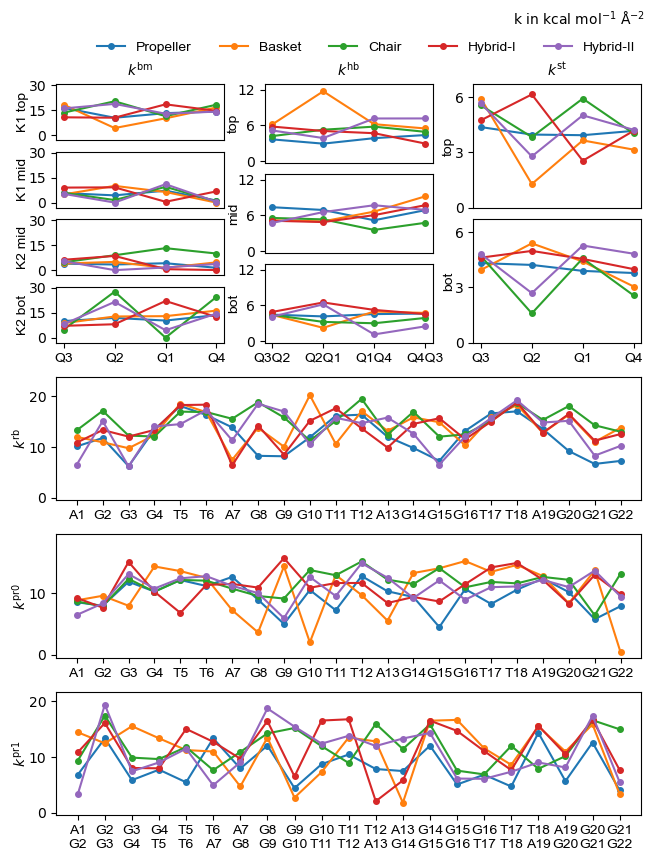

In [33]:
system_offical_name2label = {
'Propeller': 'Propeller',
'Basket'   : 'Basket',
'Chair'    : 'Chair',
'Hybrid-I' : 'Hybrid-I',
'Hybrid-II': 'Hybrid-II',
}
fig = vsplot(system_offical_name2label, is_error_bar=False)
fig.savefig('pic/ks_g4dna.svg', transparent=True)

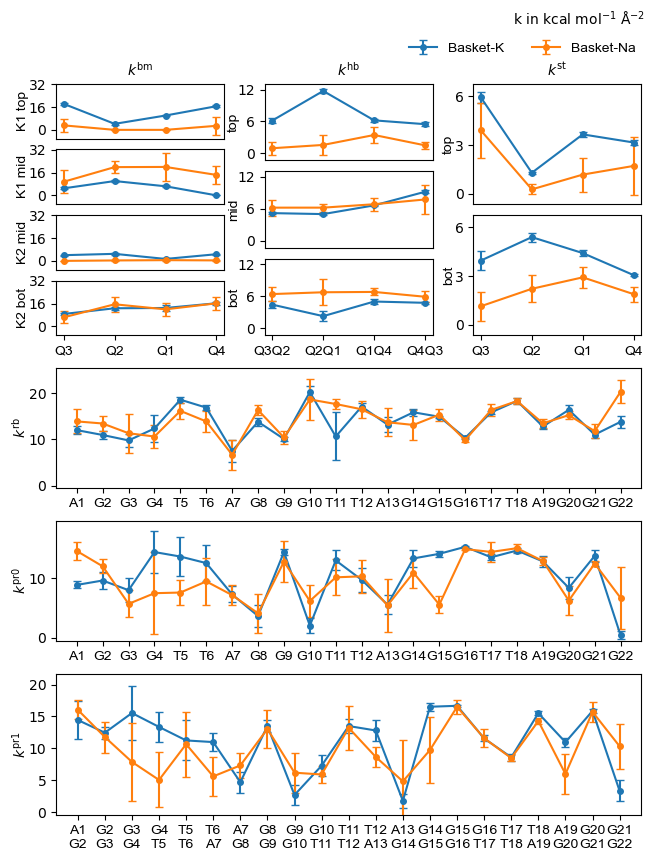

In [8]:
system_offical_name2label = {
'Basket'   : 'Basket-K',
'Basket-Na': 'Basket-Na',
}
fig = vsplot(system_offical_name2label)
fig.savefig('pic/ks_basket_basketna.svg', transparent=True)

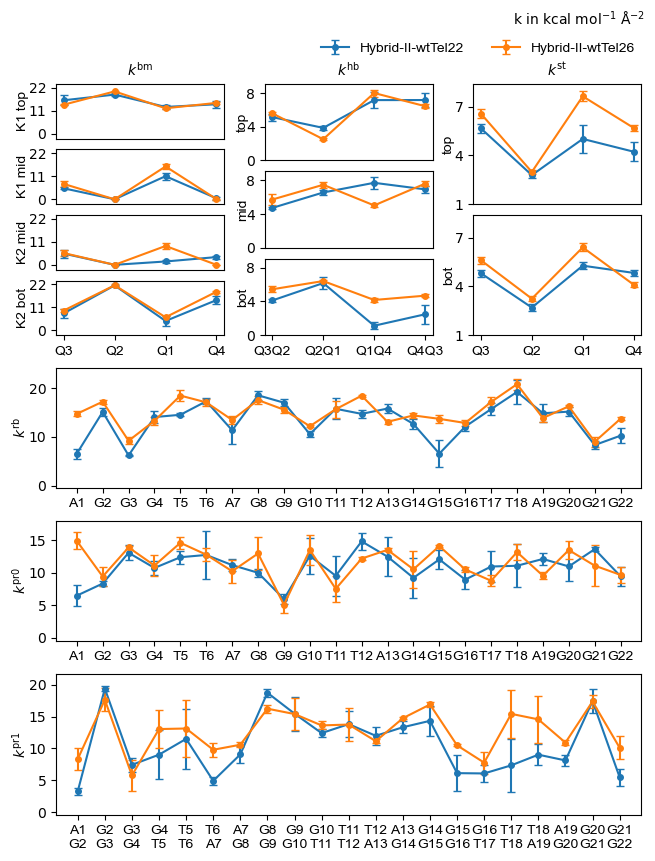

In [9]:
system_offical_name2label = {
'Hybrid-II'         : 'Hybrid-II-wtTel22',
'Hybrid-II-wtTel26' : 'Hybrid-II-wtTel26', 
}
fig = vsplot(system_offical_name2label)
fig.savefig('pic/ks_hybrid_ii_wtTel22_wtTel26.svg', transparent=True)

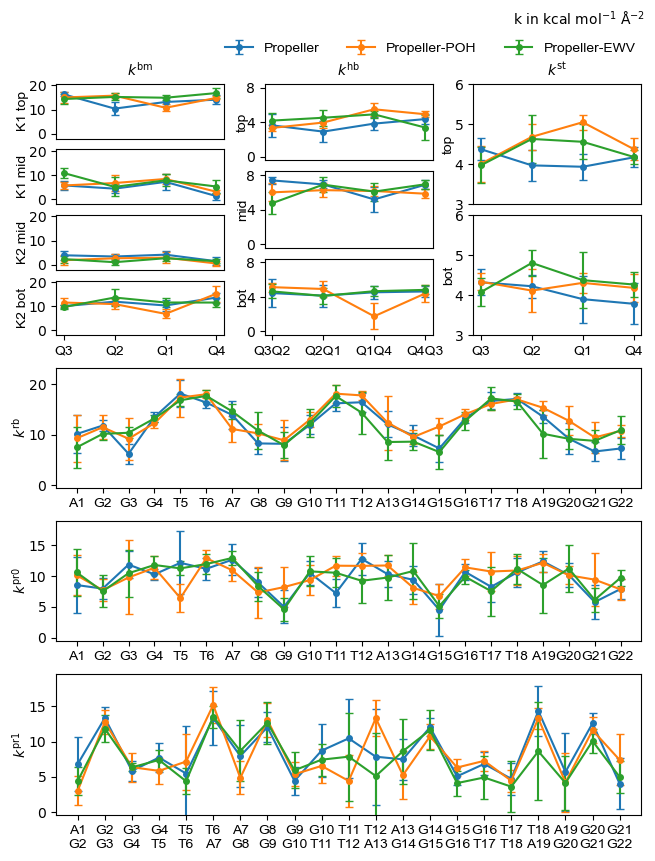

In [10]:
system_offical_name2label = {
'Propeller'    : 'Propeller',
'Propeller-POH': 'Propeller-POH',
'Propeller-EWV': 'Propeller-EWV', 
}
fig = vsplot(system_offical_name2label)
fig.savefig('pic/ks_propeller_apo_ewv_poh.svg', transparent=True)

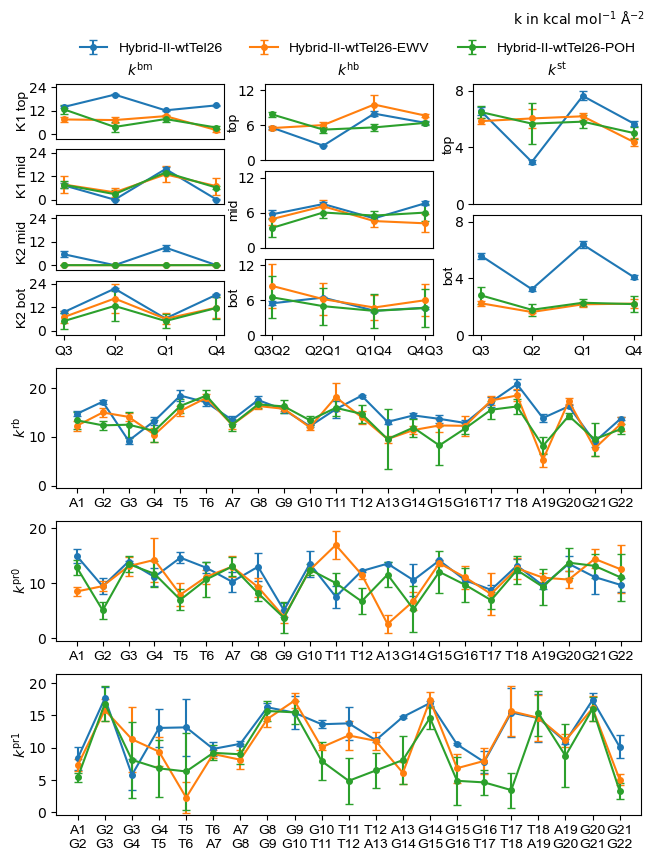

In [11]:
system_offical_name2label = {
'Hybrid-II-wtTel26'    : 'Hybrid-II-wtTel26',
'Hybrid-II-wtTel26-EWV': 'Hybrid-II-wtTel26-EWV', 
'Hybrid-II-wtTel26-POH': 'Hybrid-II-wtTel26-POH', 
}
fig = vsplot(system_offical_name2label)
fig.savefig('pic/ks_hybrid-ii_wttel26_apo_ewv_poh.svg', transparent=True)